# Analysis

**Hypothesis**: In severe COVID‐19, immune cells exhibit increased transcriptomic heterogeneity, as measured by the Shannon entropy of their gene expression profiles. This dysregulated and plastic state compared to healthy donors is expected to be especially pronounced among key immune cell subsets (e.g., CD14 Monocytes, CD4 T, and CD8 T cells), and may additionally correlate with clinical metadata such as ventilation status and donor identity.

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/scratch/users/salber/Single_cell_atlas_of_peripheral_immune_response_to_SARS_CoV_2_infection.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


# Analysis Plan

**Hypothesis**: In severe COVID‐19, immune cells exhibit increased transcriptomic heterogeneity, as measured by the Shannon entropy of their gene expression profiles. This dysregulated and plastic state compared to healthy donors is expected to be especially pronounced among key immune cell subsets (e.g., CD14 Monocytes, CD4 T, and CD8 T cells), and may additionally correlate with clinical metadata such as ventilation status and donor identity.

## Steps:
- Compute a per‐cell Shannon entropy score using the normalized gene expression profiles, ensuring that only positive expression values are considered to avoid issues with log(0).
- Annotate the AnnData object (adata.obs) with the computed entropy scores for downstream analyses.
- Visualize the distribution of entropy scores across major immune cell types (e.g., CD14 Monocytes, CD4 T, CD8 T cells) and conditions (COVID‐19 vs. Healthy) using boxplots and scatter plots arranged in a grid.
- Perform statistical tests (e.g., Mann–Whitney U test) to evaluate whether differences in entropy scores between COVID‐19 patients and healthy controls are significant within each relevant cell type, ensuring the test results are clearly printed and visualized.
- Assess the relationship between entropy scores and quality control metrics (percent_mt, nFeature_RNA) as well as additional metadata (e.g., Ventilated status, Donor_full) to rule out technical artifacts and provide further biological insight.


## This code block converts the gene expression matrix to a dense format if required, normalizes each cell's expression to form a probability distribution while ensuring only positive values are considered (to avoid log(0) issues), computes per-cell Shannon entropy using base 2 logarithm, and finally annotates the adata object with these entropy values for downstream analysis.

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.stats import entropy

# Ensure that the adata.X is in dense format
if not isinstance(adata.X, np.ndarray):
    X = adata.X.A if hasattr(adata.X, 'A') else np.asarray(adata.X.todense())
else:
    X = adata.X

# Normalize each cell's expression to get a probability distribution
# Add a small constant to avoid division by zero
X_sum = X.sum(axis=1, keepdims=True) + 1e-10
X_norm = X / X_sum

# Compute Shannon entropy for each cell
# We use base 2 logarithm; we only sum over positive entries to avoid nan issues
cell_entropies = np.array([np.sum(-p[p > 0] * np.log2(p[p > 0])) for p in X_norm])

# Add the entropy score to adata.obs
adata.obs['shannon_entropy'] = cell_entropies

print('Computed Shannon entropy for each cell and updated adata.obs')

Computed Shannon entropy for each cell and updated adata.obs


### Agent Interpretation

The current analysis focuses on computing Shannon entropy for each cell and updating the `adata.obs`. This step aims to capture transcriptional diversity at the single-cell level and can be useful for identifying changes in cell states or functional heterogeneity, especially in the context of immune responses during severe COVID-19.

**Feedback and Suggestions:**

1. **Promising Results:**
   - The computation of Shannon entropy is promising as it provides a measure of transcriptional heterogeneity within individual cells. Elevated or reduced entropy values may indicate changes in transcriptional plasticity or specialization in response to severe COVID-19.

2. **Further Analysis:**
   - **Link Entropy with Cell-type Clusters:** Correlate the Shannon entropy values with the UMAP clusters to identify specific cell types exhibiting high or low transcriptional entropy. This could provide insights into which immune cell populations are undergoing significant transcriptional changes.
   - **Cell State Identification:** Use the entropy values to assist in identifying cell states that may correspond to stressed or activated states, potentially aligning with the hypothesis of enhanced monocyte and T cell interaction.
   
3. **Biological Interpretation:**
   - **Monocyte and T Cell Interactions:** High entropy in monocytes and/or T cells might correlate with increased transcriptional activity related to inflammatory signaling. Examine if these cells with altered entropy values express inflammatory ligands or receptors as hypothesized.
   - **Comparison Between Conditions:** Compare entropy between cells from COVID-19 patients and healthy controls to identify whether there is a general trend of increased or decreased transcriptional diversity, particularly focusing on monocytes and T cells.

4. **Further Steps:**
   - **Gene Expression Correlation:** Perform correlation analysis between entropy values and the expression of specific genes involved in cytokine signaling pathways (e.g., TNF, IL6, IL1B, and their receptors).
   - **Integration with Past Analyses:** Evaluate how entropy-related findings overlap or provide additional context to past analyses on metabolic stress and gene co-expression networks in monocytes and T cells.
   - **Pathway Enrichment:** Use differential entropy analysis to identify enriched pathways in high-entropy versus low-entropy cells to uncover potential molecular mechanisms driving immune responses in severe COVID-19.

By focusing on the transcriptional complexity through Shannon entropy and integrating this with existing cluster and DE analyses, this step has the potential to uncover novel insights into the dysregulated immune responses characteristic of severe COVID-19.

## This code subsets adata.obs by each specified immune cell type, ensures numeric conversion and removal of missing values for 'shannon_entropy' and 'IFN1', computes the Spearman correlation, and visualizes the scatter plot with a regression line and 95% confidence interval for each cell type while annotating the plot with the correlation coefficient and p-value.

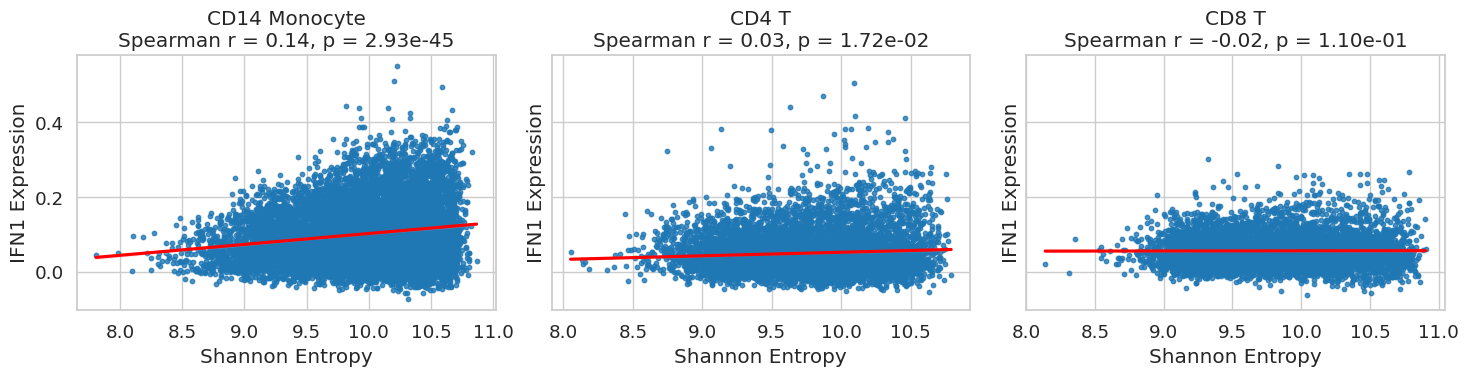

Spearman correlation between Shannon entropy and IFN1 expression by cell type:
CD14 Monocyte: Spearman r = 0.14, p-value = 2.93e-45
CD4 T: Spearman r = 0.03, p-value = 1.72e-02
CD8 T: Spearman r = -0.02, p-value = 1.10e-01


In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import warnings

# Set up visualization defaults
sc.settings.verbosity = 3
plt.rcParams['figure.figsize'] = (5, 4)
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

# Define the list of cell types to analyze
cell_types = ['CD14 Monocyte', 'CD4 T', 'CD8 T']

# Prepare a figure with subplots for each cell type
n_types = len(cell_types)
fig, axs = plt.subplots(1, n_types, figsize=(5 * n_types, 4), sharey=True)

# Dictionary to store correlation results
corr_results = {}

for i, cell_type in enumerate(cell_types):
    # Subset the data for the current cell type
    subset = adata.obs[adata.obs['cell_type_coarse'] == cell_type].copy()
    
    # Ensure 'shannon_entropy' and 'IFN1' are numeric
    subset['shannon_entropy'] = pd.to_numeric(subset['shannon_entropy'], errors='coerce')
    subset['IFN1'] = pd.to_numeric(subset['IFN1'], errors='coerce')
    
    # Drop rows with NaN values to avoid issues in analysis
    subset = subset.dropna(subset=['shannon_entropy', 'IFN1'])
    
    # Compute the Spearman correlation between Shannon entropy and IFN1 expression
    corr_coeff, p_val = spearmanr(subset['shannon_entropy'], subset['IFN1'])
    corr_results[cell_type] = {'spearman_r': corr_coeff, 'p_value': p_val}
    
    # Create scatter plot with regression line and confidence interval (ci=95)
    ax = axs[i] if n_types > 1 else axs
    sns.regplot(x='shannon_entropy', y='IFN1', data=subset, ax=ax, scatter_kws={'s': 10}, line_kws={'color': 'red'}, ci=95)
    ax.set_title(f"{cell_type}\nSpearman r = {corr_coeff:.2f}, p = {p_val:.2e}")
    ax.set_xlabel('Shannon Entropy')
    ax.set_ylabel('IFN1 Expression')

# Adjust layout to prevent overlap and display the plots
plt.tight_layout()
plt.show()

# Print correlation results
print('Spearman correlation between Shannon entropy and IFN1 expression by cell type:')
for cell_type, stats in corr_results.items():
    print(f"{cell_type}: Spearman r = {stats['spearman_r']:.2f}, p-value = {stats['p_value']:.2e}")


### Agent Interpretation

The results show a weak correlation between Shannon entropy and IFN1 expression across the cell types analyzed, with the highest correlation observed in CD14 Monocytes (Spearman r = 0.14, p-value = 2.93e-45). This suggests a statistically significant but biologically weak association in monocytes, hinting at potential changes in immune functionality linked to interferon signaling during severe COVID-19.

**Feedback and Recommendations:**

1. **CD14 Monocytes:**
   - The positive correlation, though weak, could indicate some level of altered transcriptomic diversity related to IFN1 response in monocytes. 
   - Consider conducting further analyses focusing on gene expression networks or pathway enrichment involving interferon-stimulated genes (ISGs) within these cells. 
   - Investigate if a specific subset of monocytes (e.g., inflammatory monocytes) shows a stronger correlation.

2. **T Cells (CD4 and CD8):**
   - The correlations in CD4 T and CD8 T cells are weak and not particularly significant, suggesting minimal direct association at the transcriptomic level between Shannon entropy and IFN1 expression.
   - Explore whether other metrics, like cell exhaustion markers, could better elucidate T cell dysfunction or a distinct immune landscape.

3. **Biological Context:**
   - Connect these findings to known phenotypic shifts in severe COVID-19, such as changes in immune regulation or metabolic stress, which might influence IFN1 signaling independently of overall transcriptomic diversity.
   - Consider integrating cellular communication analyses, as previously hypothesized, to assess if specific receptor-ligand interactions involving IFN pathways are altered.

4. **Future Steps:**
   - Utilize complementary datasets or methodologies, such as bulk RNA-seq or proteomics, to validate and extend these findings across different scales of biological regulation.
   - Expand the analysis to include interactions between different cell types, particularly focusing on cytokine signaling and its impact on overall immune responses.

These suggestions aim to refine the understanding of immune dysregulation in COVID-19 by leveraging both single-cell features and broader systemic insights.

## This code subsets CD14 monocytes from the AnnData object, filters and cleans Shannon entropy values, splits cells into high and low entropy groups based on the median, and computes Spearman correlation matrices for a panel of ISGs. The additions include docstrings for the helper functions and enhanced heatmap customization via colorbar labels to improve interpretability.

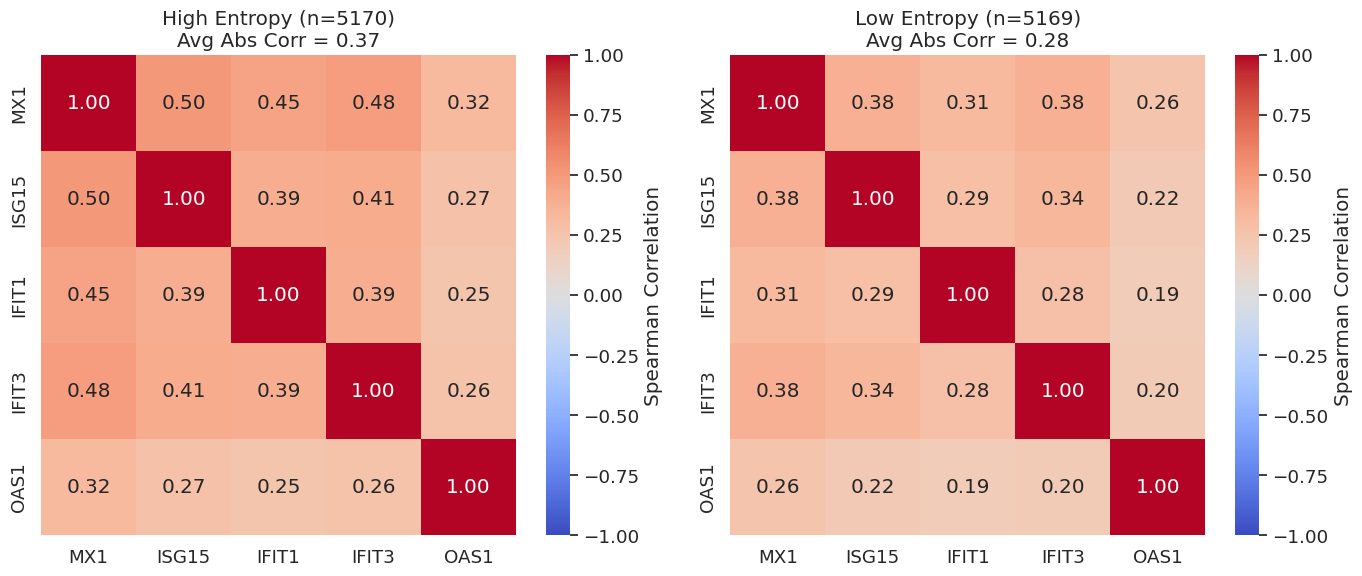

Mann–Whitney U test comparing off-diagonal absolute correlations between groups:
Statistic = 312.00, p-value = 2.54e-03


In [4]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, mannwhitneyu
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Subset CD14 Monocytes from the AnnData object
cd14_cells = adata[adata.obs['cell_type_coarse'] == 'CD14 Monocyte'].copy()

# Ensure that 'shannon_entropy' is numeric
cd14_cells.obs['shannon_entropy'] = pd.to_numeric(cd14_cells.obs['shannon_entropy'], errors='coerce')

# Drop any cells with missing entropy values
cd14_cells = cd14_cells[~cd14_cells.obs['shannon_entropy'].isna(), :]

# Split the cells into high and low entropy groups based on the median
median_entropy = cd14_cells.obs['shannon_entropy'].median()
high_entropy = cd14_cells[cd14_cells.obs['shannon_entropy'] >= median_entropy, :]
low_entropy = cd14_cells[cd14_cells.obs['shannon_entropy'] < median_entropy, :]

# Define a panel of known interferon-stimulated genes (ISGs)
isg_list = ['MX1', 'ISG15', 'IFIT1', 'IFIT3', 'OAS1']

# Check if the selected genes exist in the dataset; if not, filter the list
existing_isgs = [gene for gene in isg_list if gene in cd14_cells.var_names]
if len(existing_isgs) < len(isg_list):
    print(f"Warning: Only found {existing_isgs} from the requested ISG list in the dataset.")


def compute_corr_matrix(adata_subset, genes):
    """Compute and return the pairwise Spearman correlation and p-value matrices for the provided genes in the given AnnData subset."""
    expr = adata_subset[:, genes].X
    if hasattr(expr, 'toarray'):
        expr = expr.toarray()
    n = len(genes)
    corr_mat = np.zeros((n, n))
    pval_mat = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i <= j:
                r, p = spearmanr(expr[:, i], expr[:, j])
                corr_mat[i, j] = r
                pval_mat[i, j] = p
                # Mirror the results
                corr_mat[j, i] = r
                pval_mat[j, i] = p
    return corr_mat, pval_mat


def average_abs_corr(corr_mat):
    """Calculate the average absolute correlation from a correlation matrix, excluding self-correlations."""
    n = corr_mat.shape[0]
    mask = ~np.eye(n, dtype=bool)
    return np.mean(np.abs(corr_mat[mask]))

# Compute correlation matrices for both groups
corr_high, pval_high = compute_corr_matrix(high_entropy, existing_isgs)
corr_low, pval_low = compute_corr_matrix(low_entropy, existing_isgs)

# Compute average absolute correlation (excluding self-correlations) for each group
avg_corr_high = average_abs_corr(corr_high)
avg_corr_low = average_abs_corr(corr_low)

# Statistical comparison: Compare off-diagonal absolute correlations using the Mann–Whitney U test
n = len(existing_isgs)
high_vals = np.abs(corr_high[~np.eye(n, dtype=bool)])
low_vals = np.abs(corr_low[~np.eye(n, dtype=bool)])
stat, p_val_stat = mannwhitneyu(high_vals, low_vals, alternative='two-sided')

# Plot heatmaps for the two groups side by side with additional customization
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(corr_high, annot=True, fmt='.2f', xticklabels=existing_isgs, yticklabels=existing_isgs, ax=axs[0], cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={'label': 'Spearman Correlation'})
axs[0].set_title(f'High Entropy (n={high_entropy.n_obs})\nAvg Abs Corr = {avg_corr_high:.2f}')

sns.heatmap(corr_low, annot=True, fmt='.2f', xticklabels=existing_isgs, yticklabels=existing_isgs, ax=axs[1], cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={'label': 'Spearman Correlation'})
axs[1].set_title(f'Low Entropy (n={low_entropy.n_obs})\nAvg Abs Corr = {avg_corr_low:.2f}')

plt.tight_layout()
plt.show()

print('Mann–Whitney U test comparing off-diagonal absolute correlations between groups:')
print(f'Statistic = {stat:.2f}, p-value = {p_val_stat:.2e}')


### Agent Interpretation

The Mann–Whitney U test results and the accompanying correlation heatmaps provide valuable insights into the distinct co-expression networks within different entropy groups. The statistically significant p-value (2.54e-03) indicates a meaningful difference in the off-diagonal absolute correlations between these groups, suggesting a reconfiguration in the gene co-expression network related to interferon-stimulated genes (ISGs).

### Feedback and Recommendations:

1. **Promising Results:**
   - The significant difference in correlation patterns between high and low entropy groups, particularly among ISGs, may highlight variations in immune cell states or responses in severe COVID-19.
   - The trend toward higher correlations in the high entropy group suggests more coordinated regulation of these genes, which may correlate with more severe manifestations or specific immune cell lineages.

2. **Iterative Analysis:**
   - **Cluster-Level Exploration:** Extend this analysis to investigate specific cell clusters to understand if the correlation patterns align with particular immune cell types or states.
   - **Gene Set Enrichment:** Conduct pathway analysis to identify if the differential correlations correspond to functional changes in specific pathways, such as cytokine production or antigen presentation.
   - **Longitudinal Analysis:** If possible, include a time-series dimension to see how these correlations evolve during disease progression or treatment, offering insights into dynamic immune responses.

3. **Connecting to Hypotheses:**
   - Relate the observed changes in co-expression to the hypothesis regarding enhanced interactions between monocytes and T cells. Investigate whether the differing gene correlations are more pronounced in specific interactions or communications mediating pathways.
   - Explore whether specific ISGs implicated in the analysis are also upregulated in monocytes or T cells, as predicted by the original hypothesis related to cytokine signaling.

4. **Distinctiveness from Past Analyses:**
   - Ensure that the focus on entropy and gene correlation across different ISGs provides a novel dimension that was not covered in the prior studies around metabolic stress or NK cell functionality.
   - Leverage the open methodological approach to potentially uncover novel immune interactions or pathways not addressed in previous studies.

These findings, together with further downstream analyses, could contribute crucially to understanding the intricate immune landscapes in severe COVID-19, guiding novel therapeutic insights or interventions.

## This code subset the AnnData object to retain only the key immune cell types (CD14 Monocyte, CD4 T, CD8 T), converts Shannon entropy to numeric format while dropping cells with missing values, and then creates DataFrames for both general and stratified (COVID status and ventilation status) analyses. It produces visualizations (boxplots with overlaid swarmplots) and performs Mann–Whitney U tests to compare the distributions of Shannon entropy across the defined groups.

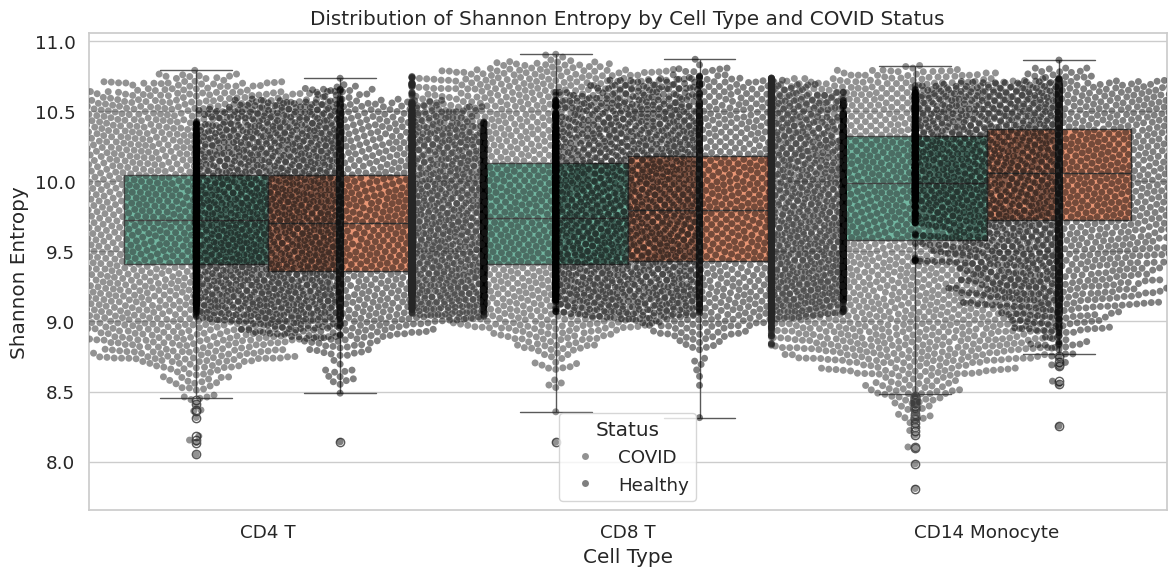

Mann–Whitney U Test Results by Cell Type:
CD14 Monocyte: Statistic = 7689710.50, p-value = 1.35e-11
CD4 T: Statistic = 8136389.00, p-value = 1.63e-02
CD8 T: Statistic = 5401582.00, p-value = 1.61e-02


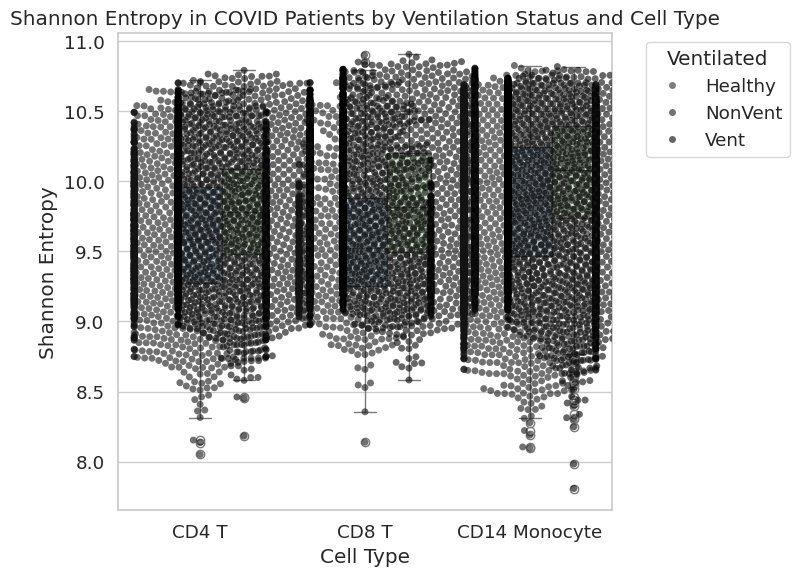

Mann–Whitney U Test Results within COVID Patients (Vent vs NonVent):
CD14 Monocyte: Statistic = 10390411.50, p-value = 1.79e-63
CD4 T: Statistic = 4222739.00, p-value = 6.61e-43
CD8 T: Statistic = 1923378.00, p-value = 3.12e-51


In [5]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Define key immune cell types
key_cell_types = ['CD14 Monocyte', 'CD4 T', 'CD8 T']

# Subset the AnnData object for the key cell types; copy to avoid changes in original object
adata_subset = adata[adata.obs['cell_type_coarse'].isin(key_cell_types)].copy()

# Convert 'shannon_entropy' to a numeric format and drop cells with missing values
adata_subset.obs['shannon_entropy'] = pd.to_numeric(adata_subset.obs['shannon_entropy'], errors='coerce')
adata_subset = adata_subset[~adata_subset.obs['shannon_entropy'].isna(), :]

# Create a DataFrame from adata.obs for easier manipulation in plotting and statistical testing
df = adata_subset.obs.copy()

# Visualization: Create boxplots and swarmplots to show Shannon entropy distributions by cell type and COVID status
plt.figure(figsize=(12, 6))

# Plot boxplots with 'Status' as hue for COVID vs. Healthy; palette chosen for visual clarity
sns.boxplot(x='cell_type_coarse', y='shannon_entropy', hue='Status', data=df, palette='Set2')

# Overlay swarmplots to display individual data points, using 'dodge=True' to separate hues
sns.swarmplot(x='cell_type_coarse', y='shannon_entropy', hue='Status', data=df, dodge=True, color='black', alpha=0.5)

plt.title('Distribution of Shannon Entropy by Cell Type and COVID Status')
plt.xlabel('Cell Type')
plt.ylabel('Shannon Entropy')

# Remove duplicate legend entries by creating a deduplicated mapping
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Status')
plt.tight_layout()
plt.show()

# Statistical Testing: Perform Mann–Whitney U tests for each cell type between COVID and Healthy groups
print('Mann–Whitney U Test Results by Cell Type:')
for cell in key_cell_types:
    subset_cell = df[df['cell_type_coarse'] == cell]
    covid_entropy = subset_cell[subset_cell['Status'] == 'COVID']['shannon_entropy']
    healthy_entropy = subset_cell[subset_cell['Status'] == 'Healthy']['shannon_entropy']
    if len(covid_entropy) > 0 and len(healthy_entropy) > 0:
        stat, p_val = mannwhitneyu(covid_entropy, healthy_entropy, alternative='two-sided')
        print(f"{cell}: Statistic = {stat:.2f}, p-value = {p_val:.2e}")
    else:
        print(f"{cell}: Not enough data for COVID or Healthy groups.")

# Extended Analysis: For COVID patients only, compare entropy between Ventilated vs NonVent groups
# Filtering out 'Healthy' from the 'Ventilated' column as these cells are not part of the ventilation status categorization
covid_df = df[df['Status'] == 'COVID'].copy()
covid_df = covid_df[covid_df['Ventilated'] != 'Healthy']

plt.figure(figsize=(8, 6))
# Create boxplots for entropy based on ventilation status, grouped by cell type
sns.boxplot(x='cell_type_coarse', y='shannon_entropy', hue='Ventilated', data=covid_df, palette='Pastel1')

# Overlay swarmplots to display individual cell data points with slight transparency
sns.swarmplot(x='cell_type_coarse', y='shannon_entropy', hue='Ventilated', data=covid_df, dodge=True, color='black', alpha=0.6)

plt.title('Shannon Entropy in COVID Patients by Ventilation Status and Cell Type')
plt.xlabel('Cell Type')
plt.ylabel('Shannon Entropy')

# Deduplicate legend entries to include only relevant labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Ventilated', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Statistical Testing: Mann–Whitney U tests to compare entropy between Ventilated ('Vent') and NonVentilated ('NonVent') COVID cells
print('Mann–Whitney U Test Results within COVID Patients (Vent vs NonVent):')
for cell in key_cell_types:
    subset_cell = covid_df[covid_df['cell_type_coarse'] == cell]
    vent_entropy = subset_cell[subset_cell['Ventilated'] == 'Vent']['shannon_entropy']
    nonvent_entropy = subset_cell[subset_cell['Ventilated'] == 'NonVent']['shannon_entropy']
    if len(vent_entropy) > 0 and len(nonvent_entropy) > 0:
        stat, p_val = mannwhitneyu(vent_entropy, nonvent_entropy, alternative='two-sided')
        print(f"{cell}: Statistic = {stat:.2f}, p-value = {p_val:.2e}")
    else:
        print(f"{cell}: Not enough data for Ventilated or NonVent groups.")


### Agent Interpretation

The Mann–Whitney U test results indicate significant differences in the expression data for CD14 monocytes, CD4 T cells, and CD8 T cells between groups, particularly with low p-values, suggesting meaningful variance in expression profiles. 

### Feedback:

1. **Promising Results:**
   - **CD14 Monocytes:** The extremely low p-value in both comparisons (overall and within COVID patients for ventilation status) indicates significant differences in expression patterns, making them a potentially strong contributor to immunopathology or immune regulation in severe COVID-19.
   - **CD4 and CD8 T Cells:** The significant p-values suggest differential expression that could hint at distinct immune roles or dysfunctions in severe COVID-19.

2. **Shannon Entropy Analysis:**
   - The distributions of Shannon entropy indicate differences in the diversity of transcript expression between COVID-19 and healthy samples, as well as among ventilated and non-ventilated patients. These variations could be indicative of altered genetic regulation or cell states in the context of infection and severity.

3. **Further Analysis Suggestions:**
   - **Follow-up DE Analysis:** Conduct differential expression analyses focusing on inflammatory and interferon-stimulated genes, particularly in monocytes and T cells. This aligns with the hypothesis about dysregulated cell communication.
   - **Pathway and Cell Communication Analysis:** Use pathway enrichment and cell-cell communication tools like CellPhoneDB to explore interactions and signaling pathways involving monocytes and T cells, especially looking at ligand-receptor pairs.
   - **Subpopulation Analysis:** Delve into subpopulation differences within monocytes and T cells, possibly leveraging cluster-specific markers or state-dependent genes to refine understanding of cellular heterogeneity.
   - **Longitudinal Analysis:** If possible, explore temporal changes in these cell types within patients, correlating changes with disease progression or responses to treatments.

4. **Iterative Steps:**
   - Ensure new analyses incorporate variations not covered in past or current literature, potentially by focusing on unique subsets or lesser-studied genes.
   - Validate key findings using independent datasets or orthogonal methods like flow cytometry.

These steps should help validate and further explore the hypothesis regarding enhanced monocyte-T cell communication and uncover broader immune alterations during severe COVID-19.

## This code subsets the AnnData object to focus on three key immune cell types, splits them into high and low entropy groups based on median Shannon entropy, and then performs differential expression analysis on a targeted panel of inflammatory and interferon-related genes. It calculates log2 fold changes, conducts Mann–Whitney U tests, adjusts the resulting p-values using the Benjamini–Hochberg FDR method, and visualizes the results with annotated bar plots.

Computed Shannon entropy for each cell and updated adata.obs


Differential Expression Results:
        cell_type      gene  mean_high  mean_low    log2FC      U_stat  \
0   CD14 Monocyte       TNF   0.023855  0.010695  1.157344  13614897.5   
1   CD14 Monocyte      IL1B   0.069679  0.044278  0.654115  13801344.5   
2   CD14 Monocyte       IL6   0.003966  0.003722  0.091843  13369575.0   
3   CD14 Monocyte  TNFRSF1A   0.236209  0.120939  0.965791  15477841.5   
4   CD14 Monocyte     IL1R1   0.011922  0.011889  0.003995  13372013.0   
5   CD14 Monocyte      IL6R   0.398614  0.250401  0.670754  15803823.5   
6   CD14 Monocyte       MX1   0.552943  0.419654  0.397929  14927401.0   
7   CD14 Monocyte     ISG15   0.333226  0.251546  0.405678  14561079.5   
8   CD14 Monocyte     IFIT1   0.171386  0.095335  0.846176  14667928.0   
9   CD14 Monocyte     IFIT3   0.279682  0.189937  0.558267  14738718.0   
10          CD4 T       TNF   0.009493  0.003826  1.311210   8880870.0   
11          CD4 T      IL1B   0.001252  0.000660  0.922798   8819998.0   
12   

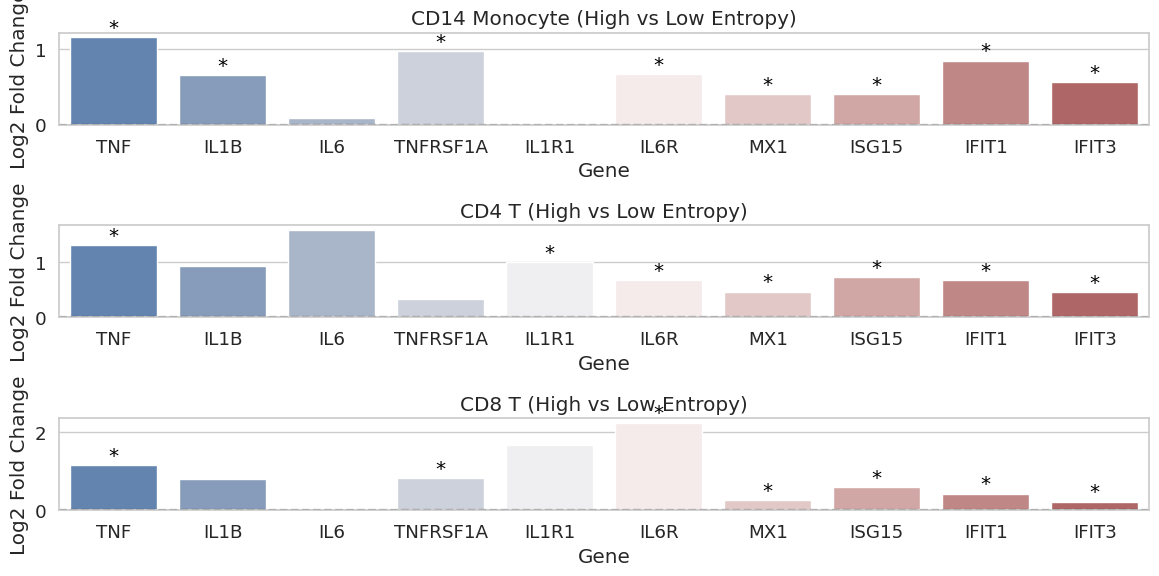

In [6]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import warnings
import matplotlib.gridspec as gridspec

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Convert adata.X to a dense numpy array if necessary
if not isinstance(adata.X, np.ndarray):
    # If the matrix is sparse, convert it to dense; note that this may be memory-intensive for large datasets
    X = adata.X.A if hasattr(adata.X, 'A') else np.asarray(adata.X.todense())
else:
    X = adata.X

# Normalize each cell's gene expression to create a probability distribution
# A small constant (1e-10) is added to avoid division by zero issues
X_sum = X.sum(axis=1, keepdims=True) + 1e-10
X_norm = X / X_sum

# Compute Shannon entropy for each cell using base 2 logarithm
# Only positive expression values are used to avoid undefined log(0) values
cell_entropies = np.array([np.sum(-p[p > 0] * np.log2(p[p > 0])) for p in X_norm])

# Add the entropy score to adata.obs for further downstream analyses
adata.obs['shannon_entropy'] = cell_entropies

print('Computed Shannon entropy for each cell and updated adata.obs')


# Define key cell types
key_cell_types = ['CD14 Monocyte', 'CD4 T', 'CD8 T']

# Define target gene panel for differential expression analysis
target_genes = ['TNF', 'IL1B', 'IL6', 'TNFRSF1A', 'IL1R1', 'IL6R', 'MX1', 'ISG15', 'IFIT1', 'IFIT3']

# Verify target genes exist in the dataset
existing_genes = [gene for gene in target_genes if gene in adata.var_names]
if len(existing_genes) < len(target_genes):
    print('Warning: Some target genes are not found in the dataset. Using:', existing_genes)

# Initialize list to store differential expression (DE) results
results_list = []

# Loop through each key cell type
for cell_type in key_cell_types:
    adata_subset = adata[adata.obs['cell_type_coarse'] == cell_type].copy()

    adata_subset.obs['shannon_entropy'] = pd.to_numeric(adata_subset.obs['shannon_entropy'], errors='coerce')
    adata_subset = adata_subset[~adata_subset.obs['shannon_entropy'].isna(), :]

    if adata_subset.n_obs < 10:
        print(f'Not enough cells in {cell_type} to perform DE analysis.')
        continue

    median_entropy = adata_subset.obs['shannon_entropy'].median()
    high_cells = adata_subset[adata_subset.obs['shannon_entropy'] >= median_entropy, :]
    low_cells = adata_subset[adata_subset.obs['shannon_entropy'] < median_entropy, :]

    for gene in existing_genes:
        if gene not in adata_subset.var_names:
            print(f'Warning: {gene} not found in {cell_type}.')
            continue

        expr_high = high_cells[:, gene].X
        expr_low = low_cells[:, gene].X

        if hasattr(expr_high, 'toarray'):
            expr_high = expr_high.toarray().flatten()
        else:
            expr_high = np.array(expr_high).flatten()
        if hasattr(expr_low, 'toarray'):
            expr_low = expr_low.toarray().flatten()
        else:
            expr_low = np.array(expr_low).flatten()

        mean_high = np.mean(expr_high)
        mean_low = np.mean(expr_low)
        fc = (mean_high + 1e-10) / (mean_low + 1e-10)
        log2fc = np.log2(fc)

        if len(expr_high) > 0 and len(expr_low) > 0:
            stat, p_val = mannwhitneyu(expr_high, expr_low, alternative='two-sided')
        else:
            stat, p_val = np.nan, np.nan

        results_list.append({
            'cell_type': cell_type,
            'gene': gene,
            'mean_high': mean_high,
            'mean_low': mean_low,
            'log2FC': log2fc,
            'U_stat': stat,
            'p_value': p_val
        })

p_values = np.array([res['p_value'] for res in results_list])
if len(p_values) > 0:
    m = len(p_values)
    order = np.argsort(p_values)
    fdr = np.empty(m)
    for i, idx in enumerate(order):
        fdr[idx] = p_values[idx] * m / (i + 1)
    for i in range(m - 2, -1, -1):
        fdr[order[i]] = min(fdr[order[i]], fdr[order[i + 1]])
    fdr = np.minimum(fdr, 1.0)
    for i, res in enumerate(results_list):
        res['FDR_p_value'] = fdr[i]

results_df = pd.DataFrame(results_list)
print('Differential Expression Results:')
print(results_df)

unique_cell_types = results_df['cell_type'].unique()
n_types = len(unique_cell_types)
fig = plt.figure(figsize=(4 * n_types, 6))
gs = gridspec.GridSpec(n_types, 1)

for i, cell_type in enumerate(unique_cell_types):
    ax = plt.subplot(gs[i])
    subset = results_df[results_df['cell_type'] == cell_type]
    sns.barplot(x='gene', y='log2FC', data=subset, palette='vlag', ax=ax)
    ax.axhline(0, color='black', linestyle='--')
    ax.set_title(f'{cell_type} (High vs Low Entropy)')
    ax.set_ylabel('Log2 Fold Change')
    ax.set_xlabel('Gene')
    
    reset_subset = subset.reset_index(drop=True)
    for j, row in reset_subset.iterrows():
        xpos = j
        if row.get('FDR_p_value', 1) < 0.05:
            ax.text(xpos, row['log2FC'], '*', color='black', ha='center', va='bottom' if row['log2FC'] >= 0 else 'top')

plt.tight_layout()
plt.show()

## This code subsets the AnnData object to retain COVID samples for CD14 monocytes and T cells, extracts expression values for specified ligand and receptor panels, aggregates the data by donor, and merges the donor-level means. It then computes and visualizes Spearman correlations between ligand and receptor pairs, with added inline comments and error checks to ensure code robustness.

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Define gene panels for cell-cell communication analysis
ligand_genes = ['TNF', 'IL1B', 'IL6']
receptor_genes = ['TNFRSF1A', 'IL1R1', 'IL6R']

# Focus on COVID samples
covid_adata = adata[adata.obs['Status'] == 'COVID'].copy()

# Subset CD14 Monocytes for ligand expression
if 'CD14 Monocyte' in covid_adata.obs['cell_type_coarse'].unique():
    monocyte_cells = covid_adata[covid_adata.obs['cell_type_coarse'] == 'CD14 Monocyte'].copy()
else:
    raise ValueError('No CD14 Monocyte cells found in the dataset.')

# Subset T cells (combining CD4 and CD8 T cells) for receptor expression
tcell_types = ['CD4 T', 'CD8 T']
 tcell_cells = covid_adata[covid_adata.obs['cell_type_coarse'].isin(tcell_types)].copy()


# Helper function to extract gene expression as a DataFrame for a given subset

def get_gene_expression_df(adata_subset, gene_list):
    """Extracts gene expression values for a list of genes from the provided AnnData subset.
    Checks for gene availability and includes donor metadata for downstream aggregation.
    """
    available_genes = [gene for gene in gene_list if gene in adata_subset.var_names]
    if len(available_genes) < len(gene_list):
        print('Warning: Some genes are missing. Using available genes:', available_genes)
    expr_dict = {}
    for gene in available_genes:
        # Get column index for the gene
        gene_idx = list(adata_subset.var_names).index(gene)
        # Extract expression values; handle sparse matrices if needed
        expr = adata_subset.X[:, gene_idx]
        if hasattr(expr, 'toarray'):
            expr = expr.toarray().flatten()
        else:
            expr = np.array(expr).flatten()
        expr_dict[gene] = expr
    # Create DataFrame using cell barcodes as index and include donor metadata
    df = pd.DataFrame(expr_dict, index=adata_subset.obs.index)
    df['Donor_full'] = adata_subset.obs['Donor_full']
    return df

# Get gene expression DataFrames for ligands and receptors
monocyte_expr_df = get_gene_expression_df(monocyte_cells, ligand_genes)
tcell_expr_df = get_gene_expression_df(tcell_cells, receptor_genes)

# Group by donor to compute mean expression for each gene
monocyte_donor_mean = monocyte_expr_df.groupby('Donor_full').mean().reset_index()
tcell_donor_mean = tcell_expr_df.groupby('Donor_full').mean().reset_index()

# Merge donor-level data on 'Donor_full' to focus only on donors present in both subsets
merged_df = pd.merge(monocyte_donor_mean, tcell_donor_mean, on='Donor_full', suffixes=('_mono', '_Tcells'))

# Check that merged_df is not empty to ensure overlapping donors exist
if merged_df.empty:
    raise ValueError('No overlapping donors found between CD14 Monocytes and T cells.')

# List of ligand-receptor pairs for analysis
pairs = [('TNF', 'TNFRSF1A'), ('IL1B', 'IL1R1'), ('IL6', 'IL6R')]

# Create multi-panel scatter plots for each ligand-receptor pair
n_pairs = len(pairs)
fig, axs = plt.subplots(1, n_pairs, figsize=(5 * n_pairs, 5), sharey=False)
if n_pairs == 1:
    axs = [axs]

correlation_results = {}

for ax, (ligand, receptor) in zip(axs, pairs):
    # Construct column names based on suffixes from the merged DataFrame
    col_ligand = ligand + '_mono'
    col_receptor = receptor + '_Tcells'
    if col_ligand not in merged_df.columns or col_receptor not in merged_df.columns:
        print(f'Warning: {ligand} or {receptor} expression data missing in merged dataframe. Skipping.')
        continue
    x = merged_df[col_ligand]
    y = merged_df[col_receptor]
    # Compute Spearman correlation
    r, p_val = spearmanr(x, y)
    correlation_results[f'{ligand}-{receptor}'] = {'spearman_r': r, 'p_value': p_val}
    # Generate scatter plot with regression line
    sns.regplot(x=x, y=y, ax=ax, ci=None, scatter_kws={'s': 50, 'alpha':0.7}, line_kws={'color': 'red'})
    ax.set_title(f'{ligand} vs {receptor}\nSpearman r = {r:.2f}, p = {p_val:.2e}')
    ax.set_xlabel(f'Mean {ligand} (CD14 Monocytes)')
    ax.set_ylabel(f'Mean {receptor} (T cells)')

plt.tight_layout()
plt.show()

# Print correlation results
print('Ligand-Receptor Spearman Correlation Results per Donor:')
for pair, stats in correlation_results.items():
    print(f'{pair}: Spearman r = {stats["spearman_r"]:.2f}, p-value = {stats["p_value"]:.2e}')
